# [GD-10] Unet ++ - Find Road By Semantic Segmentaion

<br>

## Step 1. KITTI 데이터셋 수집과 구축

### **1.1 데이터 로더(data loader) 만들기**

---

<br>

**데이터 로더**

- **입력값 `(224, 224)`, 출력값 `(224, 244)` 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 하는 역할**

<br>

**데이터 로더에 augmentation 을 적용**

- **`albumentations`을 사용**
- **Augmentation의 경우 `imgaug` 등 다른 라이브러리를 활용 가능**

<br>

```
$ pip list | grep albumentations
```

<br>


**학습셋의 일정량을 검증 데이터셋(validation dataset) 으로 활용할 수 있게 준비**

<br>

**구현시 참고 자료**

- **[Keras Sequence에 기반한 Dataloader](https://hwiyong.tistory.com/241)**
- **[Albumentation을 적용한 Keras sequence](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)**



In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

**Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 `Compose()`의 활용예**

- **imgaug의 `Sometimes()`와 유사한 기능**

In [2]:
# data augmentation function by compose() in Albumenatation
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:                     # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370), 
                w2h_ratio=370/1242, 
                height=224, 
                width=224, 
                p=0.5), 
            Resize(width=224, height=224)])
    
    # 테스용 데이터
    return Compose([Resize(width=224, height=224)])
 

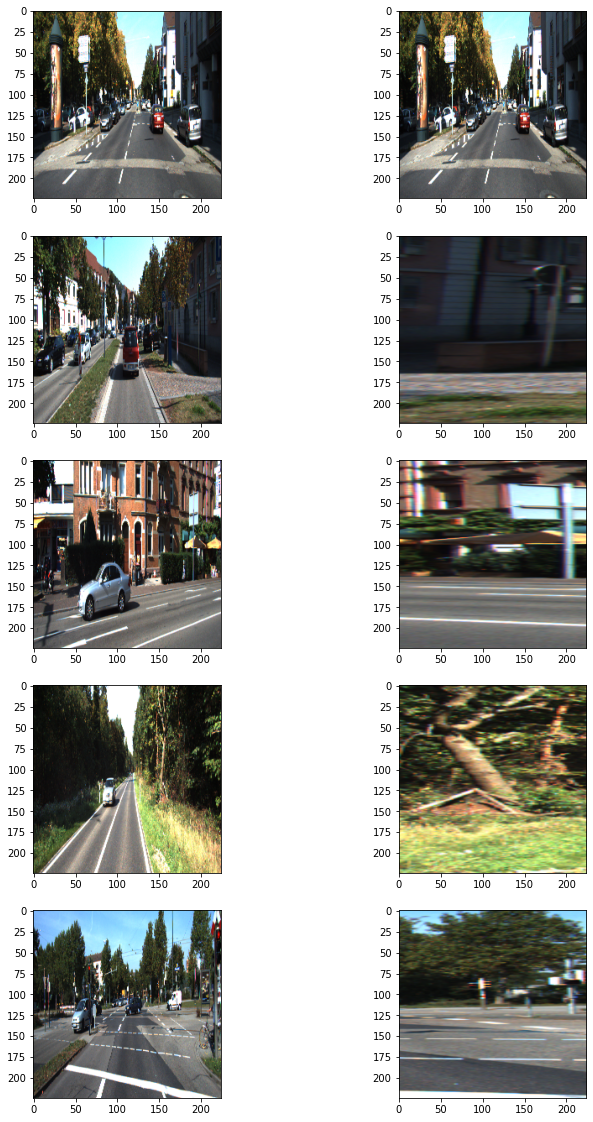

In [3]:
# augmentation 5개 적용, 시각화
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 보기 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

    
    
plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성하는 class

In [4]:
# tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성하는 class
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

augmentation & generator dataset

In [5]:
# augmentation & generator dataset
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. 모델 구현

### 2.1 U-Net 모델 구현

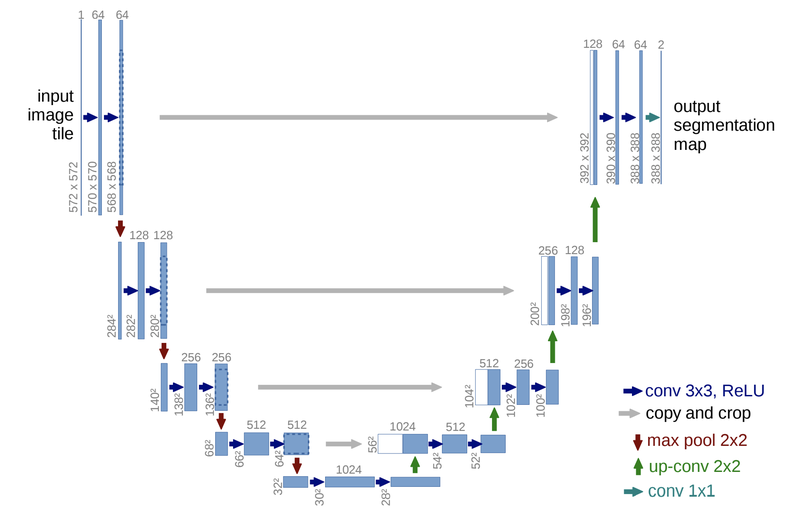

In [6]:
# U-Net 구현
def build_model(input_shape=(224, 224, 3)):
    
    #contracting Path
    inputs = Input(input_shape, name='Input')
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d1_conv1')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d1_conv2')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2), name='b2_pool')(conv1)    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d2_conv1')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d2_conv2')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), name='b3_pool')(conv2)    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d3_conv1')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d3_conv2')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2), name='b4_pool')(conv3)    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d4_conv1')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d4_conv2')(conv4)
    drop4 = Dropout(0.5, name='d4_drop')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2), name='b5_pool')(drop4)    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d5_conv1')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='d5_conv2')(conv5)
    
    # Expanding Path
    drop5 = Dropout(0.5, name='u1_drop')(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal', name='u1_convTran')(drop5)
    merge6 = concatenate([drop4, up6], axis=3, name='u1_concate')
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u1_conv1')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u1_conv2')(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal', name='u2_convTran')(conv6)
    merge7 = concatenate([conv3, up7], axis=3, name='u2_concate')
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u2_conv1')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u2_conv2')(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal', name='u3_convTran')(conv7)
    merge8 = concatenate([conv2, up8], axis=3, name='u3_concate')
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u3_conv1')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u3_conv2')(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal', name='u4_convTran')(conv8)
    merge9 = concatenate([conv1, up9], axis=3, name='u4_concate')
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u4_conv1')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u4_conv2')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal', name='u4_conv3')(conv9)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv9)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [7]:
u_model = build_model()
u_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
d1_conv1 (Conv2D)               (None, 224, 224, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
d1_conv2 (Conv2D)               (None, 224, 224, 64) 36928       d1_conv1[0][0]                   
__________________________________________________________________________________________________
b2_pool (MaxPooling2D)          (None, 112, 112, 64) 0           d1_conv2[0][0]                   
______________________________________________________________________________________________

### **2.2 U-Net 모델 학습, 저장**

In [9]:
# 모델 학습, 모델 저장
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet = build_model()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet.save(model_path)  #학습한 모델을 저장

Epoch 1/100
11/11 [==============================] - 9s 652ms/step - loss: 0.6924 - val_loss: 0.6830
Epoch 2/100
11/11 [==============================] - 7s 632ms/step - loss: 0.6729 - val_loss: 0.6349
Epoch 3/100
11/11 [==============================] - 7s 626ms/step - loss: 0.2471 - val_loss: 0.0339
Epoch 4/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0319 - val_loss: 0.0341
Epoch 5/100
11/11 [==============================] - 7s 608ms/step - loss: 0.0372 - val_loss: 0.0353
Epoch 6/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0347 - val_loss: 0.0305
Epoch 7/100
11/11 [==============================] - 7s 610ms/step - loss: 0.0272 - val_loss: 0.0271
Epoch 8/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0251 - val_loss: 0.0320
Epoch 9/100
11/11 [==============================] - 7s 616ms/step - loss: 0.0285 - val_loss: 0.0361
Epoch 10/100
11/11 [==============================] - 7s 624ms/step - loss: 0.0270 - val_lo

11/11 [==============================] - 7s 628ms/step - loss: 0.0163 - val_loss: 0.0216
Epoch 82/100
11/11 [==============================] - 7s 630ms/step - loss: 0.0146 - val_loss: 0.0244
Epoch 83/100
11/11 [==============================] - 7s 622ms/step - loss: 0.0180 - val_loss: 0.0210
Epoch 84/100
11/11 [==============================] - 7s 633ms/step - loss: 0.0233 - val_loss: 0.0253
Epoch 85/100
11/11 [==============================] - 7s 633ms/step - loss: 0.0198 - val_loss: 0.0220
Epoch 86/100
11/11 [==============================] - 7s 630ms/step - loss: 0.0158 - val_loss: 0.0229
Epoch 87/100
11/11 [==============================] - 7s 631ms/step - loss: 0.0145 - val_loss: 0.0203
Epoch 88/100
11/11 [==============================] - 7s 626ms/step - loss: 0.0139 - val_loss: 0.0202
Epoch 89/100
11/11 [==============================] - 7s 631ms/step - loss: 0.0130 - val_loss: 0.0218
Epoch 90/100
11/11 [==============================] - 7s 625ms/step - loss: 0.0160 - val_loss: 

### **2.3 U-Net++ 모델 구현**

---

- **2018년에 발표한 논문**
- **U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델**
- **2020년에 한 번 업그레이드**

- **[U-Net++: v1](https://arxiv.org/abs/1807.10165)**
- **[U-Net++: v2](https://arxiv.org/abs/1912.05074)**

<br>


**모델의 구조** 

- **그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준**
- **U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것**


<br>

**참고할 수 있는 코드 keras로 구현**

- **[U-Net++:Github](https://github.com/MrGiovanni/UNetPlusPlus)**

<br>


**U-Net++ 구현 코드 중에 가장 중요한 부분**

- **[여기:build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12), 논문에서 제시하는 수식과 함께 참고요망**

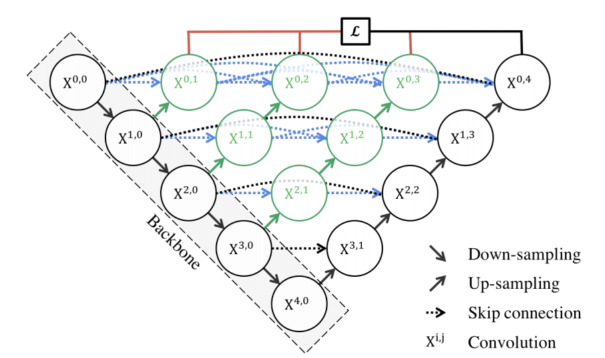

<br>


- **[UNet++: A Nested U-Net Architecture for Medical Image Segmentation](https://arxiv.org/pdf/1807.10165.pdf)**

<br>


**upsampling 코드 중 `up_block`으로는 두 가지 방식을 사용**

- **[Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53)과 [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)인데요. 둘 중 어느 것을 사용해도 좋습니다.**
- **주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점**
    - **binary cross-entropy와 dice coefficient를 사용**
    - **[dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고**

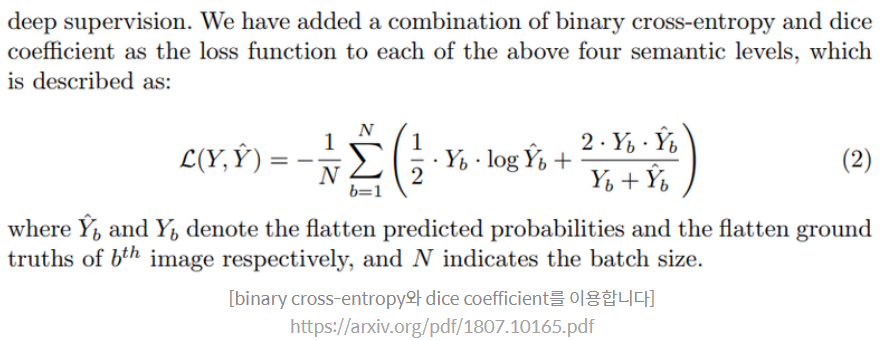

<br>


In [10]:
# U-Net 구현
def build_unet_double_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape, name='Input')
    
    # x_0
    x_0 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x0_conv1')(inputs)
    x_0 = BatchNormalization(name='x0_bn_1')(x_0)
    x_0 = Activation('relu', name='x0_act_1')(x_0)
    x_0 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x0_conv2')(x_0)
    x_0 = BatchNormalization(name='x0_bn_2')(x_0)
    x_0 = Activation('relu', name='x0_act_2')(x_0)
    
    # x_1
    x_1 = MaxPooling2D(pool_size=(2, 2), name='x1_pool')(x_0)    
    x_1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x1_conv1')(x_1)
    x_1 = BatchNormalization(name='x1_bn_1')(x_1)
    x_1 = Activation('relu', name='x1_act_1')(x_1)
    x_1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x1_conv2')(x_1)
    x_1 = BatchNormalization(name='x1_bn_2')(x_1)
    x_1 = Activation('relu', name='x1_act_2')(x_1)
    
    # x_2
    x_2 = MaxPooling2D(pool_size=(2, 2), name='x2_pool')(x_1)    
    x_2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x2_conv1')(x_2)
    x_2 = BatchNormalization(name='x2_bn_1')(x_2)
    x_2 = Activation('relu', name='x2_act_1')(x_2)
    x_2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x2_conv2')(x_2)
    x_2 = BatchNormalization(name='x2_bn_2')(x_2)
    x_2 = Activation('relu', name='x2_act_2')(x_2)    
    
    # x_3
    x_3 = MaxPooling2D(pool_size=(2, 2), name='x3_pool')(x_2)    
    x_3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', name='x3_conv1')(x_3)
    x_3 = BatchNormalization(name='x3_bn_1')(x_3)
    x_3 = Activation('relu', name='x3_act_1')(x_3)
    x_3 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', name='x3_conv2')(x_3)
    x_3 = BatchNormalization(name='x3_bn_2')(x_3)
    x_3 = Activation('relu', name='x3_act_2')(x_3)        
    
    # x_4
    x_4 = MaxPooling2D(pool_size=(2, 2), name='x4_pool')(x_3)    
    x_4 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal', name='x4_conv1')(x_4)
    x_4 = BatchNormalization(name='x4_bn_1')(x_4)
    x_4 = Activation('relu', name='x4_act_1')(x_4)
    x_4 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal', name='x4_conv2')(x_4)
    x_4 = BatchNormalization(name='x4_bn_2')(x_4)
    x_4 = Activation('relu', name='x4_act_2')(x_4)
    
    # x_0_1
    up_x_1 = Conv2DTranspose(32, 2, strides=(2, 2), kernel_initializer='he_normal', name='x1_convTran')(x_1)
    x_0_1 = concatenate([x_0, up_x_1], axis=3, name='x0_1_concate')
    
    x_0_1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x01_conv1')(x_0_1)
    x_0_1 = BatchNormalization(name='x01_bn_1')(x_0_1)
    x_0_1 = Activation('relu', name='x01_act_1')(x_0_1)
    x_0_1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x01_conv2')(x_0_1)
    x_0_1 = BatchNormalization(name='x01_bn_2')(x_0_1)
    x_0_1 = Activation('relu', name='x01_act_2')(x_0_1)    
    
    # x_1_1
    up_x_2 = Conv2DTranspose(64, 2, strides=(2, 2), kernel_initializer='he_normal', name='x2_convTran')(x_2)
    x_1_1 = concatenate([x_1, up_x_2], axis=3, name='x1_1_concate')    
    
    x_1_1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x11_conv1')(x_1_1)
    x_1_1 = BatchNormalization(name='x11_bn_1')(x_1_1)
    x_1_1 = Activation('relu', name='x11_act_1')(x_1_1)
    x_1_1 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x11_conv2')(x_1_1)
    x_1_1 = BatchNormalization(name='x11_bn_2')(x_1_1)
    x_1_1 = Activation('relu', name='x11_act_2')(x_1_1)    
    
    # x_2_1
    up_x_3 = Conv2DTranspose(128, 2, strides=(2, 2), kernel_initializer='he_normal', name='x3_convTran')(x_3)
    x_2_1 = concatenate([x_2, up_x_3], axis=3, name='x2_1_concate')    
    
    x_2_1 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x21_conv1')(x_2_1)
    x_2_1 = BatchNormalization(name='x21_bn_1')(x_2_1)
    x_2_1 = Activation('relu', name='x21_act_1')(x_2_1)
    x_2_1 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x21_conv2')(x_2_1)
    x_2_1 = BatchNormalization(name='x21_bn_2')(x_2_1)
    x_2_1 = Activation('relu', name='x21_act_2')(x_2_1)        
    
    # x_3_1
    up_x_4 = Conv2DTranspose(256, 2, strides=(2, 2), kernel_initializer='he_normal', name='x4_convTran')(x_4)
    x_3_1 = concatenate([x_3, up_x_4], axis=3, name='x3_1_concate')    
    
    x_3_1 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', name='x31_conv1')(x_3_1)
    x_3_1 = BatchNormalization(name='x31_bn_1')(x_3_1)
    x_3_1 = Activation('relu', name='x31_act_1')(x_3_1)
    x_3_1 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal', name='x31_conv2')(x_3_1)
    x_3_1 = BatchNormalization(name='x31_bn_2')(x_3_1)
    x_3_1 = Activation('relu', name='x31_act_2')(x_3_1)     
    
    # x_0_2
    up_x_1_1 = Conv2DTranspose(32, 2, strides=(2, 2), kernel_initializer='he_normal', name='x11_convTran')(x_1_1)
    x_0_2 = concatenate([x_0, x_0_1, up_x_1_1], axis=3, name='x0_2_concate')
    
    x_0_2 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x02_conv1')(x_0_2)
    x_0_2 = BatchNormalization(name='x02_bn_1')(x_0_2)
    x_0_2 = Activation('relu', name='x02_act_1')(x_0_2)
    x_0_2 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x02_conv2')(x_0_2)
    x_0_2 = BatchNormalization(name='x02_bn_2')(x_0_2)
    x_0_2 = Activation('relu', name='x02_act_2')(x_0_2)        
    
    # x_1_2
    up_x_2_1 = Conv2DTranspose(64, 2, strides=(2, 2), kernel_initializer='he_normal', name='x21_convTran')(x_2_1)
    x_1_2 = concatenate([x_1, x_1_1, up_x_2_1], axis=3, name='x1_2_concate')    
    
    x_1_2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x12_conv1')(x_1_2)
    x_1_2 = BatchNormalization(name='x12_bn_1')(x_1_2)
    x_1_2 = Activation('relu', name='x12_act_1')(x_1_2)
    x_1_2 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x12_conv2')(x_1_2)
    x_1_2 = BatchNormalization(name='x12_bn_2')(x_1_2)
    x_1_2 = Activation('relu', name='x12_act_2')(x_1_2)    
    
    # x_2_2
    up_x_3_1 = Conv2DTranspose(128, 2, strides=(2, 2), kernel_initializer='he_normal', name='x31_convTran')(x_3_1)
    x_2_2 = concatenate([x_2, x_2_1, up_x_3_1], axis=3, name='x2_2_concate')    
    
    x_2_2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x22_conv1')(x_2_2)
    x_2_2 = BatchNormalization(name='x22_bn_1')(x_2_2)
    x_2_2 = Activation('relu', name='x22_act_1')(x_2_2)
    x_2_2 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal', name='x22_conv2')(x_2_2)
    x_2_2 = BatchNormalization(name='x22_bn_2')(x_2_2)
    x_2_2 = Activation('relu', name='x22_act_2')(x_2_2)   
    
    # x_0_3
    up_x_1_2 = Conv2DTranspose(32, 2, strides=(2, 2), kernel_initializer='he_normal', name='x12_convTran')(x_1_2)
    x_0_3 = concatenate([x_0, x_0_1, x_0_2, up_x_1_2], axis=3, name='x0_3_concate')
    
    x_0_3 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x03_conv1')(x_0_3)
    x_0_3 = BatchNormalization(name='x03_bn_1')(x_0_3)
    x_0_3 = Activation('relu', name='x03_act_1')(x_0_3)
    x_0_3 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x03_conv2')(x_0_3)
    x_0_3 = BatchNormalization(name='x03_bn_2')(x_0_3)
    x_0_3 = Activation('relu', name='x03_act_2')(x_0_3)
    
    # x_1_3
    up_x_2_2 = Conv2DTranspose(64, 2, strides=(2, 2), kernel_initializer='he_normal', name='x22_convTran')(x_2_2)
    x_1_3 = concatenate([x_1, x_1_1, x_1_2, up_x_2_2], axis=3, name='x1_3_concate')    
    
    x_1_3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x13_conv1')(x_1_3)
    x_1_3 = BatchNormalization(name='x13_bn_1')(x_1_3)
    x_1_3 = Activation('relu', name='x13_act_1')(x_1_3)
    x_1_3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', name='x13_conv2')(x_1_3)
    x_1_3 = BatchNormalization(name='x13_bn_2')(x_1_3)
    x_1_3 = Activation('relu', name='x13_act_2')(x_1_3)        
    
    # x_0_4
    up_x_1_3 = Conv2DTranspose(32, 2, strides=(2, 2), kernel_initializer='he_normal', name='x13_convTran')(x_1_3)
    x_0_4 = concatenate([x_0, x_0_1, x_0_2, x_0_3, up_x_1_3], axis=3, name='x0_4_concate')
    
    x_0_4 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x04_conv1')(x_0_4)
    x_0_4 = BatchNormalization(name='x04_bn_1')(x_0_4)
    x_0_4 = Activation('relu', name='x04_act_1')(x_0_4)
    x_0_4 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', name='x04_conv2')(x_0_4)
    x_0_4 = BatchNormalization(name='x04_bn_2')(x_0_4)
    x_0_4 = Activation('relu', name='x04_act_2')(x_0_4)    
    
 
    output = Conv2D(1, 1, activation='sigmoid', name='final')(x_0_4)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

모델 생성, 모델 구조보기

In [11]:
unet_dp = build_unet_double_plus()
unet_dp.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
x0_conv1 (Conv2D)               (None, 224, 224, 32) 896         Input[0][0]                      
__________________________________________________________________________________________________
x0_bn_1 (BatchNormalization)    (None, 224, 224, 32) 128         x0_conv1[0][0]                   
__________________________________________________________________________________________________
x0_act_1 (Activation)           (None, 224, 224, 32) 0           x0_bn_1[0][0]                    
____________________________________________________________________________________________

### **2.4 U-Net++ 모델 학습, 저장**

In [13]:
# tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성하는 class
class KittiGenerator1(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=8,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [14]:
# augmentation & generator dataset
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator1 = KittiGenerator1(
    dir_path, 
    augmentation=augmentation,
)

test_generator1 = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [15]:
# 모델 학습, 모델 저장
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_dp.h5'

unet_dp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet_dp.fit(
     train_generator1,
     validation_data=test_generator1,
     steps_per_epoch=len(train_generator1),
     epochs=100,
 )

unet_dp.save(model_path)  #학습한 모델을 저장

Epoch 1/100
22/22 [==============================] - 17s 414ms/step - loss: 0.5380 - val_loss: 0.6516
Epoch 2/100
22/22 [==============================] - 8s 352ms/step - loss: 0.4190 - val_loss: 0.6242
Epoch 3/100
22/22 [==============================] - 8s 354ms/step - loss: 0.3463 - val_loss: 0.6110
Epoch 4/100
22/22 [==============================] - 8s 359ms/step - loss: 0.3013 - val_loss: 0.6161
Epoch 5/100
22/22 [==============================] - 8s 356ms/step - loss: 0.2703 - val_loss: 0.6194
Epoch 6/100
22/22 [==============================] - 8s 359ms/step - loss: 0.2427 - val_loss: 0.6441
Epoch 7/100
22/22 [==============================] - 8s 362ms/step - loss: 0.2301 - val_loss: 0.6478
Epoch 8/100
22/22 [==============================] - 8s 362ms/step - loss: 0.2237 - val_loss: 0.5963
Epoch 9/100
22/22 [==============================] - 8s 366ms/step - loss: 0.2092 - val_loss: 0.5226
Epoch 10/100
22/22 [==============================] - 8s 365ms/step - loss: 0.1975 - val_l

22/22 [==============================] - 8s 369ms/step - loss: 0.0462 - val_loss: 0.0524
Epoch 82/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0510 - val_loss: 0.0750
Epoch 83/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0551 - val_loss: 0.0395
Epoch 84/100
22/22 [==============================] - 8s 369ms/step - loss: 0.0474 - val_loss: 0.0512
Epoch 85/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0443 - val_loss: 0.0411
Epoch 86/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0463 - val_loss: 0.0443
Epoch 87/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0426 - val_loss: 0.0461
Epoch 88/100
22/22 [==============================] - 8s 367ms/step - loss: 0.0429 - val_loss: 0.0496
Epoch 89/100
22/22 [==============================] - 8s 367ms/step - loss: 0.0453 - val_loss: 0.0517
Epoch 90/100
22/22 [==============================] - 8s 368ms/step - loss: 0.0468 - val_loss: 

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

### **3.1 추론(inference)한 결과를  세그멘테이션 이미지로 만들기 & IOU계산함수**

---

- **모델의 출력값을 입력 이미지 위에 겹쳐서 보이기(오버레이(overray))**
- **PIL 패키지를 사용하신다면 `Image.blend`를 활용**

In [ ]:
# # 저장한 모델 불러오기
# model_path = dir_path + '/seg_model_unet.h5' 

# unet = tf.keras.models.load_model(model_path)

In [16]:
# IoU(Intersection over Union)를 계산 함수
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [17]:
# 시각화 & IOU score 구하는 함수
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### 3.2 Unet 세그멘테이션 결과 &IOU

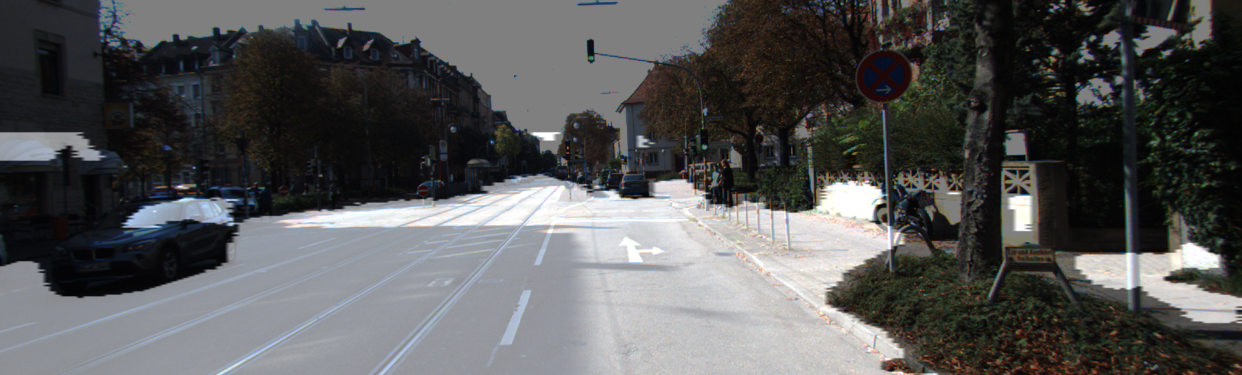

IoU : 0.778116


0.7781164468773327

In [18]:
# 추론 결과 시각화 &  iou score 구하기
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### 3.3 Unet++ 세그멘테이션 결과 & IOU

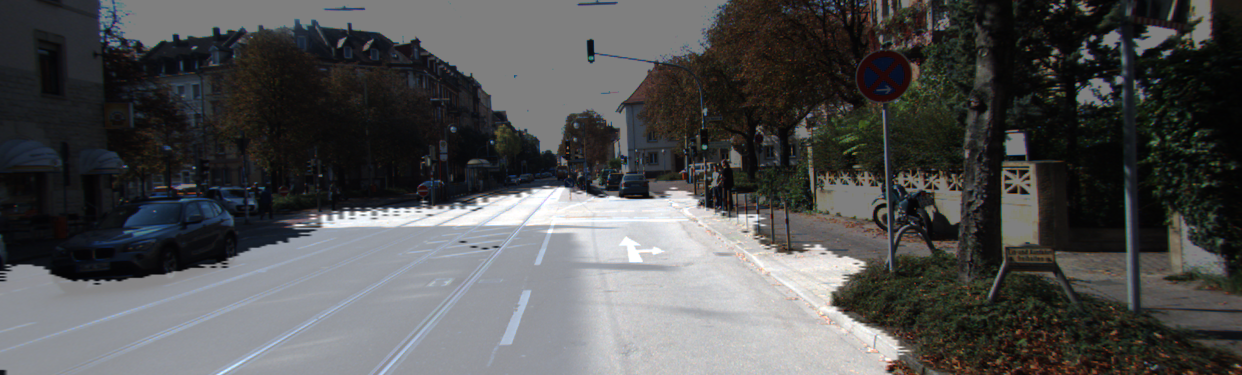

IoU : 0.892639


0.8926393728222997

In [19]:
# 추론 결과 시각화 &  iou score 구하기
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output1, prediction1, target1 = get_output(
     unet_dp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target1, prediction1)

### 3.4 비교분석

1. U-Net
- 인도를 도로영역으로 많은 부분이 segmentation되어서 성능이 떨어지는 것 같다.
2. U-Net++
- 인도를 도로영역으로 segmentation하는 것이 조금은 U-Net보다 좋은 것 같다.
- 0.12 정도의 차이가 월등히 좋은 것인가?? 

## 회고
- 이번 프로젝트에서 **어려웠던 점**
    - U-Net++ 모델을 구현하는 것이 어려웠다.
    - 너무 반복적인 것이 많았다.
- 프로젝트를 진행하면서 **알아낸 점**
    - U-Net, U-Net++ 모델 구성
- 프로젝트를 진행하면서 **아직 모호한 점**  
    - binary cross-entropy와 dice coefficient을 어떻게 구현해야 하는 지 잘 모르겠다.
    - 내가 loss를 직접 구현해야 했던 것일까?
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**
    - 직접 모델을 만들기 위해 노력한 것
- 반복적인 구간이 많았는 데, 그것을 block화 하지 못한 것이 아쉽다.
- 레이어 만드는 것이 생각보다 시간이 많이 걸려서.. ㅜ.ㅜ